# Handwritten Digit Classification

## Introduction

The project will implement Neural Networks to classify the handwritten digits' using Neural Networks. The objective is to understand how the Neural Networks works compared to the Regularized Logistic Regression. The dataset is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset.

I'd like to thank Andrew Ng. This project is inspired from the Machine Learning course by [Andrew Ng (Stanford University)](https://www.coursera.org/learn/machine-learning/home/welcome) in Coursera.

The project consists of the following sections,

| Section | Part                                            |Explanation                                    | 
|---------|:-                                               |:-                                             |
| 1       | [Review](#section1)                             | Theories review about NN |
| 2       | [Define Neural Networks Class](#section2)     | The class serves as a self-built Neural Network algorithm |
| 3       | [Handwritten Digit Classification with NN Class](#section3)     | Evaluate the NN model         |
| 4       | [Conclusion](#section4)     | Take aways of the project         |

<a id="section1"></a>
## 1:  Review

In this section, we will define a Neural Network class to classify the handwritten digit. The NN architecture is as follows,

![Neural network](Figures/neural_network.png)

The architecture has 3 layers: an input layer, a hidden layer and an output layer. The input layer contains 400 units (20x20 pixels). The hidden layer has 25 hidden units. The output layer has 10 outputs. 

In this project, we are going to implement an end-to-end Machine Learning project with Neural Networks. the weights ($\Theta^{(1)}$, $\Theta^{(2)}$) are already obtained from the backpropagation. The NN class will only implement the forwardpropagation to predict using the existing weights.

The cost function (with regularization) of NN is as follows,

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

with,

m = training examples

K = dataset labels

$h_\theta \left( x^{(i)} \right)$ = $a_k^{(3)}$

<a id="section2"></a>
## 2:  Define a Neural Network class 
The pipeline will be,

| Pipeline | Part               |Explanation                       | 
| ---------|:-                  |:-                                |
| 1        | Load the dataset   | Load X, y, and initialize the initial weights (symmetry breaking) |
| 2        | Plot the dataset   | Using Matplotlib pyplot (code snippet from Andrew Ng)          |
| 3        | Sigmoid            | To calculate the $h_{\theta}$ (equivalent of $a_3$ in this project)   |
| 4        | Cost Function      | Cost of Regularized Neural Networks for classification |
| 5        | Scipy Optimization | Using `scipy.optimize.minimize`  |
| 6        | Prediction         | Given $\theta_1$ and $\theta_2$, return the predicted label  |

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat # to load the .mat dataset
%matplotlib inline

In [2]:
class NeuralNetwork:
    def __init__(self, input_units, hidden_units, num_labels):
        '''
        The method will load the dataset and initialize important values. 
        
        STEPS
        -----
        1. Loading dataset : Refer to the load_data method for details
        2. Define the important values.
            input_layer_size : number of input units
            hidden_layer_size : number of hidden layers' units
            num_lables : number of labels
            initial_Theta1 : Numpy arrays of the Initial Theta1
            initial_Theta2 : Numpy arrays of the Initial Theta2
        3. Unroll parameters
            Roll the initial_Theta1 and initial_Theta2 into a single variable initial_nn_params
        '''
        
        # STEP 1
        self.load_data()
        
        # STEP 2
        self.input_layer_size  = input_units
        self.hidden_layer_size = hidden_units
        self.num_labels = num_labels
        self.initial_Theta1 = self.init_weights(self.input_layer_size, self.hidden_layer_size)
        self.initial_Theta2 = self.init_weights(self.hidden_layer_size, self.num_labels)

        # STEP 3
        self.initial_nn_params = np.concatenate([self.initial_Theta1.ravel(), self.initial_Theta2.ravel()], axis=0)
        
    def load_data(self):
        '''
        The method will load the dataset from a CSV file named 'ex4data1.txt'.
        Note: The raw dataset has been shuffled randomly before.
        
        STEPS
        -----
        1. Load the CSV file
        2. Assign the following variables,
            m : number of dataset examples
            X : training set features,
                X[0][0] : 1st pixel of the first image
                X[0][1] : 2nd pixel of the first image
                X[m][n] : nth pixel of the mth image
            y : Handwritten digit labels,
                y=10 : Digit 0
                y=1  : Digit 1
                ...
                y=9  : Digit 9
        3. Load the weights
        '''
        
        # STEP 1
        self.dataset = loadmat(os.path.join('Data', 'ex4data1.mat'))
        
        # STEP 2
        self.X = self.dataset['X']
        self.y = self.dataset['y'].ravel()
        
        # set the zero digit to 0, rather than its mapped 10 in this dataset
        # This is an artifact due to the fact that this dataset was used in 
        # MATLAB where there is no index 0
        self.y[self.y == 10] = 0
        # convert labels to ints if their type is bool
        if self.y.dtype == bool:
            self.y = self.y.astype(int)
        
        self.m = self.y.size
        
        # STEP 3
        self.weights = loadmat(os.path.join('Data', 'ex4weights.mat'))
        self.Theta1, self.Theta2 = self.weights['Theta1'], self.weights['Theta2']
        
        # swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
        # since the weight file ex3weights.mat was saved based on MATLAB indexing
        self.Theta2 = np.roll(self.Theta2, 1, axis=0)
        self.nn_params = np.concatenate([self.Theta1.ravel(), self.Theta2.ravel()])

        
    def init_weights(self, L_in, L_out, epsilon_init = 0.12):
        '''
        The methhod will initialize randomly the initial weights of a layer in a 
        neural network. It is important to randomly init weights to have a symmetry 
        breaking. The method is inspired from Andrew Ng.
        
        PARAMETERS
        ----------
        L_in : int
            Number of incomming connections.

        L_out : int
            Number of outgoing connections. 

        epsilon_init : float, optional
            Range of values which the weight can take from a uniform 
            distribution.

        RETURNS
        -------
        weights : array_like
            The weight initialiatized to random values.  Note that W should
            be set to a matrix of size(L_out, 1 + L_in) as
            the first column of W handles the "bias" terms.
        '''
        
        weights = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
        
        return weights

    
    def plot_data(self, X, example_width=None, figsize=(10, 10)):
        '''
        The method will select examples randomly and plot it.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing n features values of all examples.
        
        STEPS
        -----
        1. Select 100 examples randomly
        2. Plot the selected examples
        '''
        
        # ====================== STEP 1 ======================
        rand_idx = np.random.choice(self.m, 100, replace=False)
        selected_datapoints = X[rand_idx, :]

        # ====================== STEP 2 ======================
        # Plot the selected_datapoints
        if selected_datapoints.ndim == 2:
            self.m, self.n = selected_datapoints.shape
        elif selected_datapoints.ndim == 1:
            self.n = selected_datapoints.size
            self.m = 1
            selected_datapoints = selected_datapoints[None]  # Promote to a 2 dimensional array
        else:
            raise IndexError('Input X should be 1 or 2 dimensional.')

        example_width = example_width or int(np.round(np.sqrt(self.n)))
        example_height = self.n / example_width

        # Compute number of items to display
        display_rows = int(np.floor(np.sqrt(self.m)))
        display_cols = int(np.ceil(self.m / display_rows))

        fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
        fig.subplots_adjust(wspace=0.025, hspace=0.025)

        ax_array = [ax_array] if self.m == 1 else ax_array.ravel()

        for i, ax in enumerate(ax_array):
            ax.imshow(selected_datapoints[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
            ax.axis('off')

            
    def sigmoid(self, z):
        '''
        The method will calculate the sigmoid function.
        
        PARAMETERS
        ----------
        z : Numpy array
            A vector of shape (m, 1) from a matrix multiplication of theta and X
            
        RETURNS
        -------
        g : Numpy array
            A vector of shape (m,1) of h_theta
        '''
        
        # Calculate the h_theta
        g = 1 / (1 + np.exp(-z))
        
        return g
    
    
    def sigmoid_gradient(self, z):
        '''
        The method will calculate the gradient of the sigmoid function.
        
        PARAMETERS
        ----------
        z : Numpy array
            A vector of shape (m, 1) from a matrix multiplication of theta and X
            
        RETURNS
        -------
        grad : Numpy array
            A vector of shape (m,1) of h_theta
        '''
        
        # Calculate the h_theta
        grad = self.sigmoid(z) * (1 - self.sigmoid(z))
        
        return grad
    
    
    def compute_cost_nn(self, nn_params, X, y):
        '''
        The method will compute the regularized cost of the NN. The cost 
        function will be referred later for the scipy optimization algorithm.
        
        PARAMETERS
        ----------
        nn_params : Numpy array
               Refer to the __init__ method.
        X : Numpy array
            A matrix of shape (m, n), containing all examples' features values
            and unit bias
        y : Numpy array
            A vector of shape (m, 1), containing all examples' labels
            
        RETURNS
        -------
        J : float
            Given the theta, return the cost of the model
        grad : Numpy array
            A vector of shape (number_of_layers,1), containing the gradient of each layer
            
        STEPS
        -----
        1. Initialize important values,
        2. Calculate the values of a1, a2, and a3,
        3. Calculate the cost,
        4. Perform backpropagation.
        '''
        
        # ====================== STEP 1 ======================
        # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
        # for our 2 layer neural network
        Theta1 = np.reshape(nn_params[:self.hidden_layer_size * (self.input_layer_size + 1)], (self.hidden_layer_size, (self.input_layer_size + 1)))

        Theta2 = np.reshape(nn_params[(self.hidden_layer_size * (self.input_layer_size + 1)):], (self.num_labels, (self.hidden_layer_size + 1)))
        
        # convert labels to ints if their type is bool
        if y.dtype == bool:
            y = y.astype(int)
        
        y_matrix = y.reshape(-1)
        y_matrix = np.eye(self.num_labels)[y_matrix]
    
        temp1 = Theta1
        temp2 = Theta2
        
        # ====================== STEP 2 ======================
        # Calculate the values of a1, a2, and a3
        a1 = X.copy()
        
        # Calculate and add bias term to the a2
        a2 = self.sigmoid(np.dot(a1, Theta1.T))
        bias_unit_a2 = np.ones((a2.shape[0], 1))
        a2 = np.hstack((bias_unit_a2, a2))
        
        # Calculate the output
        a3 = self.sigmoid(np.dot(a2, Theta2.T))
        
        # ====================== STEP 3 ======================
        # Calculate the cost
        
        regularization_term = (self.lambda_ / (2 * self.m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))
        
        J = (1/self.m) * np.sum(-y_matrix * np.log(a3) - (1-y_matrix) * np.log(1-a3)) + regularization_term
                
        # ====================== STEP 4 ======================
        # Backpropagation to calculate the gradient
        delta3 = a3 - y_matrix
        delta2 = np.dot(delta3, Theta2)[:, 1:] * self.sigmoid_gradient(np.dot(a1, Theta1.T))
        
        Delta1 = np.dot(delta2.T, a1)
        Delta2 = np.dot(delta3.T, a2)
        
        Theta1_grad = (1 / self.m) * Delta1
        Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (self.lambda_ / self.m) * Theta1[:, 1:]

        Theta2_grad = (1 / self.m) * Delta2
        Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (self.lambda_ / self.m) * Theta2[:, 1:]
        
        grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
        
        return J, grad
    
    
    def scipy_optimize(self, X, y, _lambda, maxiter):
        '''
        The method uses a Conjugate Gradient algorithm (CG) in the Scipy 
        Optimization. Please refer to the Review section.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing all examples' labels
        y : Numpy array
            A vector of shape (m, 1), containing all examples' labels
        num_labels : int
            Number of labels of the datasets
        lambda_ : float
            The hyperparameter for regularization  
        maxiter : int
            Number of max iterations allowed for the scipy.optimize

        RETURNS
        -------
        all_theta : Numpy array
            A matrix of shape (K, n+1), for K is number of classes.
            The matrix contains optimized thetas for each K from CG.
            
        STEPS
        -----
        1. Add bias term to the features' values
        2. Define important values
        3. Scipy optimization
        '''
        
        # STEP 1
        bias_unit = np.ones((X.shape[0], 1))
        X_with_bias = np.hstack((bias_unit, X))
        
        # STEP 2
        initial_nn_params = self.initial_nn_params.copy()
        self.lambda_ = lambda_
        
        # STEP 3
        options = {'maxiter' : maxiter}
        
        res = optimize.minimize(self.compute_cost_nn,
                                initial_nn_params,
                                (X_with_bias, self.y),
                                jac=True,
                                method='CG',
                                options=options)
        
        nn_params = res.x
        
        # Obtain Theta1 and Theta2 back from nn_params
        Theta1 = np.reshape(nn_params[:self.hidden_layer_size * (self.input_layer_size + 1)],
                    (self.hidden_layer_size, (self.input_layer_size + 1)))

        Theta2 = np.reshape(nn_params[(self.hidden_layer_size * (self.input_layer_size + 1)):],
                    (self.num_labels, (self.hidden_layer_size + 1)))
        
        return Theta1, Theta2
    
                                    
    def predict(self, X, Theta1, Theta2):
        '''
        The method will predict the digits given the X and thetas.
        Moreover, calculate the predictions' probability.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing all examples features'
            values
        Theta1 : Numpy array
            A matrix of shape (input_units + 1, hidden_layer_units + 1)
        Theta2 : Numpy array
            A matrix of shape (hidden_layer_units + 1, output_units)
            
        RETURNS
        -------
        label : Numpy array
                A vector of shape (m,1), containing the label of
                the digits
                
        STEPS
        -----
        1. Add bias term to the X
        2. Calculate the sigmoid function
        3. Assign the prediction based on the probability threshold (0.5)
        '''
        
        # STEP 1
        bias_unit = np.ones((X.shape[0],1))
        X_with_bias = np.hstack((bias_unit, X))
        
        # STEP 2
        #layer 2
        a2 = self.sigmoid(np.dot(X_with_bias, Theta1.T))
        add_bias_unit_a2 = np.ones((a2.shape[0], 1))
        a2 = np.hstack((add_bias_unit_a2, a2)) 
        
        #layer3
        a3 = self.sigmoid(np.dot(a2, Theta2.T))
        
        # STEP 3
        label = np.argmax(a3, axis = 1)
        
        return label

<a id="section3"></a>
## 3:  Handwritten Digit Classification with LG Class 
In section 3, we will predict the Digit using Neural Network class. Let's initiate important parameters first,

In [3]:
input_layer_size  = 400  # 20 pixels x 20 pixels Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

After defined, let's instantiate the class,

In [4]:
handwritten_digit = NeuralNetwork(input_layer_size, hidden_layer_size, num_labels)
X = handwritten_digit.X.copy()
y = handwritten_digit.y.copy()

The figure below shows the 100 randomly chosen examples from the dataset,

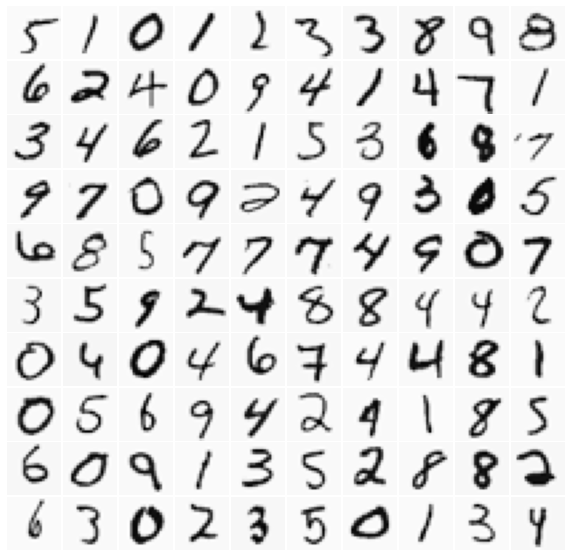

In [5]:
handwritten_digit.plot_data(X)
plt.show()

Before we begin the optimization (learning) process, let's define the important parameters,

In [6]:
lambda_ = 0.1 # Regularization parameter
maxiter = 100 # Max iterations allowed for scipy

Let's begin the optimization process using `scipy.optimize` `CG` method,

In [7]:
theta1, theta2 = handwritten_digit.scipy_optimize(X, y, lambda_, maxiter)

The `scipy_optimize` return the optimized `Theta1` and `Theta2`. Let's evaluate the model accuracy,

In [8]:
predicted_label = handwritten_digit.predict(X, theta1, theta2)
print('Model Accuracy: {:.2f} %'.format(np.mean(predicted_label == y) * 100))

Model Accuracy: 99.18 %


The model has the accuracy of around **~99%**. The accuracy fluctuated due to the random initialization of the weights. It is higher than the previous project **97.5%** (Regularized Logistic Regression) and **97.5%** (NN with existing weights). It is possible to increase the existing model's accuracy (even up to 100%) by tweaking the $\lambda$ parameter. However, user should be aware the risk of overfitting.

<a id="section4"></a>
## 4:  Conclusion
In this project, we have successfully implemented an end-to-end Neural Networks algorithm to classify handwritten digits. The Neural Networks model able to classify the handwritten digits with the accuracy around **~99%**. The accuracy fluctuation is due to the random initialization of the weights (for symmetry breaking).

Last but not least, I'd like to thank Andrew Ng for the inspiration to work on the project.